In [1]:
"""
Mini Diffusion Model for Text-to-MNIST Generation
Generates MNIST digits from text prompts like "zero", "one", etc.
Optimized for Google Colab (CPU/GPU T4)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
# ============================================================================
# 1. HYPERPARAMETERS
# ============================================================================
batch_size = 128
epochs = 20
learning_rate = 1e-3
timesteps = 1000
img_size = 28

In [3]:
# ============================================================================
# 2. LOAD AND PREPROCESS MNIST
# ============================================================================
print("Loading MNIST dataset...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.92MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.40MB/s]


In [4]:
# ============================================================================
# 3. TEXT LABEL ENCODING
# ============================================================================
digit_to_text = {
    0: "zero", 1: "one", 2: "two", 3: "three", 4: "four",
    5: "five", 6: "six", 7: "seven", 8: "eight", 9: "nine"
}

# Simple one-hot encoding for text labels
def encode_text_label(label, num_classes=10):
    """Convert digit label to one-hot encoding"""
    return F.one_hot(torch.tensor(label), num_classes=num_classes).float()


In [5]:
# ============================================================================
# 4. NOISE SCHEDULER (Linear β schedule)
# ============================================================================
class NoiseScheduler:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps

        # Linear schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x0, t, noise=None):
        """Forward diffusion: add noise to clean image"""
        if noise is None:
            noise = torch.randn_like(x0)

        sqrt_alpha_bar = torch.sqrt(self.alpha_bars[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bars[t])[:, None, None, None]

        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def sample_timestep(self, batch_size):
        """Sample random timesteps"""
        return torch.randint(0, self.timesteps, (batch_size,), device=device)

scheduler = NoiseScheduler(timesteps=timesteps)


In [6]:
# ============================================================================
# 5. MINI U-NET MODEL
# ============================================================================
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, text_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)

        # Time and text embedding projection
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.text_mlp = nn.Linear(text_emb_dim, out_ch)

    def forward(self, x, t_emb, text_emb):
        h = self.conv1(x)
        h = self.norm1(h)

        # Add time and text embeddings
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = h + self.text_mlp(text_emb)[:, :, None, None]
        h = F.relu(h)

        h = self.conv2(h)
        h = self.norm2(h)
        h = F.relu(h)
        return h

class MiniUNet(nn.Module):
    def __init__(self, img_channels=1, text_emb_dim=10, time_emb_dim=32, base_channels=64):
        super().__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Text embedding MLP
        self.text_mlp = nn.Sequential(
            nn.Linear(text_emb_dim, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, text_emb_dim)
        )

        # Encoder
        self.enc1 = ConvBlock(img_channels, base_channels, time_emb_dim, text_emb_dim)
        self.enc2 = ConvBlock(base_channels, base_channels * 2, time_emb_dim, text_emb_dim)
        self.enc3 = ConvBlock(base_channels * 2, base_channels * 2, time_emb_dim, text_emb_dim)

        # Bottleneck
        self.bottleneck = ConvBlock(base_channels * 2, base_channels * 2, time_emb_dim, text_emb_dim)

        # Decoder
        self.dec3 = ConvBlock(base_channels * 4, base_channels * 2, time_emb_dim, text_emb_dim)
        self.dec2 = ConvBlock(base_channels * 4, base_channels, time_emb_dim, text_emb_dim)
        self.dec1 = ConvBlock(base_channels * 2, base_channels, time_emb_dim, text_emb_dim)

        # Output
        self.out = nn.Conv2d(base_channels, img_channels, 1)

        self.pool = nn.MaxPool2d(2)

    def upsample_and_match(self, x, target_size):
        """Upsample and match exact target size"""
        x = F.interpolate(x, size=target_size, mode='bilinear', align_corners=True)
        return x

    def forward(self, x, t, text_emb):
        # Process embeddings
        t_emb = self.time_mlp(t)
        text_emb = self.text_mlp(text_emb)

        # Encoder - save sizes for skip connections
        enc1 = self.enc1(x, t_emb, text_emb)  # 28x28
        enc2 = self.enc2(self.pool(enc1), t_emb, text_emb)  # 14x14
        enc3 = self.enc3(self.pool(enc2), t_emb, text_emb)  # 7x7

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3), t_emb, text_emb)  # 3x3

        # Decoder with skip connections - match sizes exactly
        dec3 = self.dec3(torch.cat([self.upsample_and_match(bottleneck, enc3.shape[2:]), enc3], dim=1), t_emb, text_emb)
        dec2 = self.dec2(torch.cat([self.upsample_and_match(dec3, enc2.shape[2:]), enc2], dim=1), t_emb, text_emb)
        dec1 = self.dec1(torch.cat([self.upsample_and_match(dec2, enc1.shape[2:]), enc1], dim=1), t_emb, text_emb)

        return self.out(dec1)

In [7]:
# ============================================================================
# 6. TRAINING
# ============================================================================
model = MiniUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(f"\nModel has {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Starting training for {epochs} epochs...\n")

losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for images, labels in pbar:
        images = images.to(device)
        batch_size_current = images.shape[0]

        # Create text embeddings (one-hot)
        text_emb = torch.stack([encode_text_label(l.item()) for l in labels]).to(device)

        # Sample random timesteps
        t = scheduler.sample_timestep(batch_size_current)

        # Add noise
        noisy_images, noise = scheduler.add_noise(images, t)

        # Predict noise
        noise_pred = model(noisy_images, t, text_emb)

        # Compute loss
        loss = criterion(noise_pred, noise)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")



Model has 1,622,731 parameters
Starting training for 20 epochs...



Epoch 1/20: 100%|██████████| 469/469 [00:47<00:00,  9.96it/s, loss=0.0372]


Epoch 1 - Average Loss: 0.0692


Epoch 2/20: 100%|██████████| 469/469 [00:45<00:00, 10.41it/s, loss=0.0332]


Epoch 2 - Average Loss: 0.0342


Epoch 3/20: 100%|██████████| 469/469 [00:44<00:00, 10.50it/s, loss=0.0322]


Epoch 3 - Average Loss: 0.0305


Epoch 4/20: 100%|██████████| 469/469 [00:44<00:00, 10.48it/s, loss=0.0255]


Epoch 4 - Average Loss: 0.0282


Epoch 5/20: 100%|██████████| 469/469 [00:45<00:00, 10.42it/s, loss=0.0212]


Epoch 5 - Average Loss: 0.0269


Epoch 6/20: 100%|██████████| 469/469 [00:45<00:00, 10.40it/s, loss=0.0251]


Epoch 6 - Average Loss: 0.0253


Epoch 7/20: 100%|██████████| 469/469 [00:44<00:00, 10.45it/s, loss=0.0216]


Epoch 7 - Average Loss: 0.0249


Epoch 8/20: 100%|██████████| 469/469 [00:44<00:00, 10.46it/s, loss=0.0301]


Epoch 8 - Average Loss: 0.0245


Epoch 9/20: 100%|██████████| 469/469 [00:44<00:00, 10.48it/s, loss=0.0244]


Epoch 9 - Average Loss: 0.0244


Epoch 10/20: 100%|██████████| 469/469 [00:44<00:00, 10.52it/s, loss=0.0201]


Epoch 10 - Average Loss: 0.0239


Epoch 11/20: 100%|██████████| 469/469 [00:44<00:00, 10.50it/s, loss=0.0215]


Epoch 11 - Average Loss: 0.0235


Epoch 12/20: 100%|██████████| 469/469 [00:44<00:00, 10.48it/s, loss=0.0243]


Epoch 12 - Average Loss: 0.0235


Epoch 13/20: 100%|██████████| 469/469 [00:44<00:00, 10.43it/s, loss=0.0219]


Epoch 13 - Average Loss: 0.0234


Epoch 14/20: 100%|██████████| 469/469 [00:44<00:00, 10.54it/s, loss=0.0238]


Epoch 14 - Average Loss: 0.0233


Epoch 15/20: 100%|██████████| 469/469 [00:46<00:00, 10.16it/s, loss=0.0219]


Epoch 15 - Average Loss: 0.0229


Epoch 16/20: 100%|██████████| 469/469 [00:46<00:00, 10.11it/s, loss=0.0191]


Epoch 16 - Average Loss: 0.0232


Epoch 17/20: 100%|██████████| 469/469 [00:48<00:00,  9.58it/s, loss=0.021]


Epoch 17 - Average Loss: 0.0227


Epoch 18/20: 100%|██████████| 469/469 [00:45<00:00, 10.32it/s, loss=0.0181]


Epoch 18 - Average Loss: 0.0225


Epoch 19/20: 100%|██████████| 469/469 [00:44<00:00, 10.50it/s, loss=0.0177]


Epoch 19 - Average Loss: 0.0227


Epoch 20/20: 100%|██████████| 469/469 [00:45<00:00, 10.35it/s, loss=0.0236]

Epoch 20 - Average Loss: 0.0225


In [8]:
#============================================================================
# 7. SAMPLING FUNCTION
# ============================================================================
@torch.no_grad()
def sample(model, scheduler, text_prompt, num_samples=1, img_size=28):
    """Generate images from text prompt"""
    model.eval()

    # Convert text to label
    text_to_digit = {v: k for k, v in digit_to_text.items()}
    if text_prompt not in text_to_digit:
        print(f"Invalid prompt. Use: {list(text_to_digit.keys())}")
        return None

    label = text_to_digit[text_prompt]
    text_emb = encode_text_label(label).unsqueeze(0).repeat(num_samples, 1).to(device)

    # Start from random noise
    x = torch.randn(num_samples, 1, img_size, img_size).to(device)

    # Reverse diffusion process
    for i in tqdm(reversed(range(scheduler.timesteps)), desc="Sampling"):
        t = torch.full((num_samples,), i, dtype=torch.long, device=device)

        # Predict noise
        predicted_noise = model(x, t, text_emb)

        # Denoise step
        alpha = scheduler.alphas[i]
        alpha_bar = scheduler.alpha_bars[i]
        beta = scheduler.betas[i]

        if i > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        # DDPM sampling formula
        x = (1 / torch.sqrt(alpha)) * (
            x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * predicted_noise
        ) + torch.sqrt(beta) * noise

    return x


In [9]:
# ============================================================================
# 8. VISUALIZATION
# ============================================================================
def visualize_samples(samples, text_prompt):
    """Display generated images"""
    samples = samples.cpu()
    samples = (samples + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    samples = torch.clamp(samples, 0, 1)

    fig, axes = plt.subplots(1, len(samples), figsize=(2*len(samples), 2))
    if len(samples) == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.imshow(samples[i, 0], cmap='gray')
        ax.axis('off')
        ax.set_title(f'"{text_prompt}"')

    plt.tight_layout()
    plt.show()


Generating samples for all digits...

Generating: zero


Sampling: 1000it [00:03, 253.25it/s]


Generating: one


Sampling: 1000it [00:03, 258.49it/s]


Generating: two


Sampling: 1000it [00:04, 221.83it/s]


Generating: three


Sampling: 1000it [00:03, 258.88it/s]


Generating: four


Sampling: 1000it [00:04, 248.92it/s]


Generating: five


Sampling: 1000it [00:04, 227.20it/s]


Generating: six


Sampling: 1000it [00:03, 261.31it/s]


Generating: seven


Sampling: 1000it [00:04, 245.37it/s]


Generating: eight


Sampling: 1000it [00:04, 231.10it/s]


Generating: nine


Sampling: 1000it [00:03, 255.69it/s]


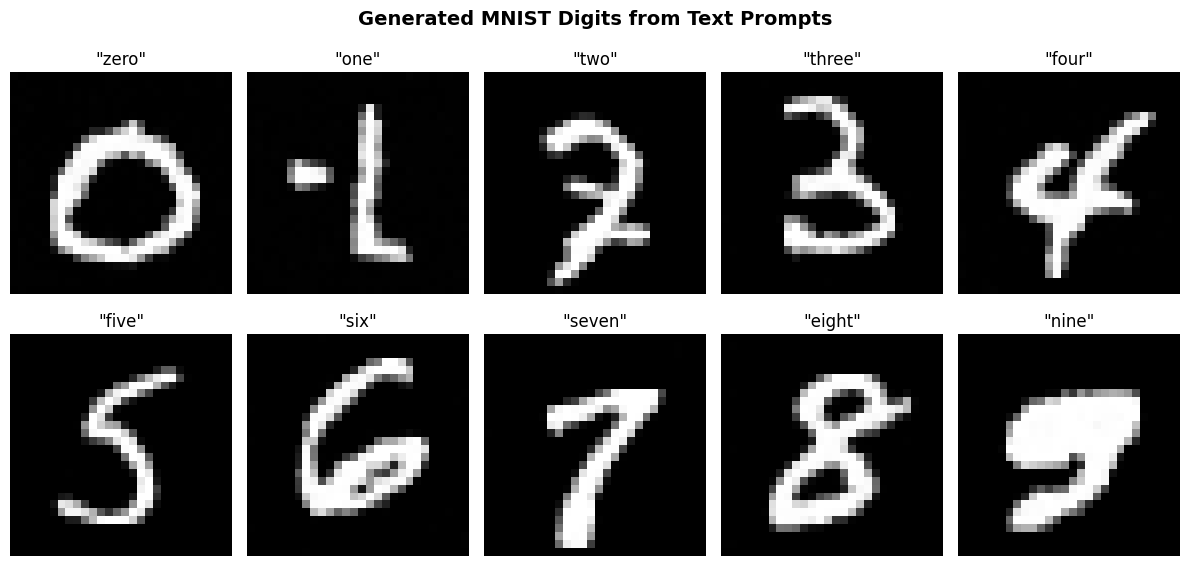

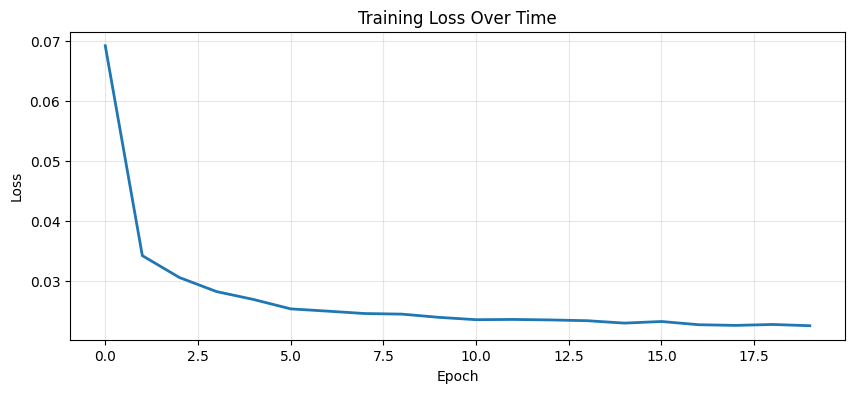

In [10]:
# ============================================================================
# 9. GENERATE SAMPLES FOR ALL DIGITS
# ============================================================================
print("\nGenerating samples for all digits...\n")

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for digit in range(10):
    text_prompt = digit_to_text[digit]
    print(f"Generating: {text_prompt}")

    generated = sample(model, scheduler, text_prompt, num_samples=1)

    if generated is not None:
        img = generated[0, 0].cpu()
        img = (img + 1) / 2  # Denormalize
        img = torch.clamp(img, 0, 1)

        axes[digit].imshow(img, cmap='gray')
        axes[digit].set_title(f'"{text_prompt}"')
        axes[digit].axis('off')

plt.suptitle('Generated MNIST Digits from Text Prompts', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# 10. TRAINING LOSS PLOT
# ============================================================================
plt.figure(figsize=(10, 4))
plt.plot(losses, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)
plt.show()



In [11]:
# ============================================================================
# 11. SAVE MODEL
# ============================================================================
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'losses': losses,
}, 'mnist_diffusion_model.pth')

print("\n✓ Model saved as 'mnist_diffusion_model.pth'")




✓ Model saved as 'mnist_diffusion_model.pth'


In [12]:
# ============================================================================
# 12. INTERACTIVE GENERATION
# ============================================================================
print("\n" + "="*60)
print("INTERACTIVE GENERATION")
print("="*60)
print("\nGenerate custom digits by running:")
print("  generated = sample(model, scheduler, 'three', num_samples=4)")
print("  visualize_samples(generated, 'three')")
print("\nAvailable prompts:", list(digit_to_text.values()))


INTERACTIVE GENERATION

Generate custom digits by running:
  generated = sample(model, scheduler, 'three', num_samples=4)
  visualize_samples(generated, 'three')

Available prompts: ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']



INTERACTIVE GENERATION

You can generate custom digit images using your trained diffusion model!
Available prompts: ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

Example: 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'

Enter a digit prompt (or type 'exit' to quit): five
Enter number of samples to generate (e.g. 4): 4

🧠 Generating 4 samples for prompt 'five'...



Sampling: 1000it [00:03, 259.38it/s]


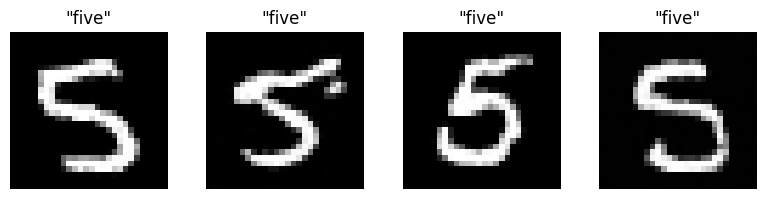


✅ Generation complete! You can generate more digits or type 'exit' to finish.

Enter a digit prompt (or type 'exit' to quit): exit
Exiting interactive generation... 👋


In [14]:
# ============================================================================
# 13. INTERACTIVE GENERATION with USER INPUT
# ============================================================================
print("\n" + "="*60)
print("INTERACTIVE GENERATION")
print("="*60)

print("\nYou can generate custom digit images using your trained diffusion model!")
print("Available prompts:", list(digit_to_text.values()))
print("\nExample: 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'")

while True:
    user_prompt = input("\nEnter a digit prompt (or type 'exit' to quit): ").strip().lower()
    if user_prompt == 'exit':
        print("Exiting interactive generation... 👋")
        break

    if user_prompt not in digit_to_text.values():
        print("❌ Invalid input. Please choose from:", list(digit_to_text.values()))
        continue

    try:
        num_samples = int(input("Enter number of samples to generate (e.g. 4): "))
    except ValueError:
        print("❌ Invalid number. Try again.")
        continue

    print(f"\n🧠 Generating {num_samples} samples for prompt '{user_prompt}'...\n")

    # Run the generation function
    generated = sample(model, scheduler, user_prompt, num_samples=num_samples)

    # Visualize the results
    visualize_samples(generated, user_prompt)

    print("\n✅ Generation complete! You can generate more digits or type 'exit' to finish.")
